# Aprendizaje Automático - Proyecto Final
## Red Neuronal

In [3]:
import random
import numpy as np
import pandas as pd
import scipy.optimize as opt
from scipy.io import loadmat
import matplotlib.pyplot as plt

import displayData as dd
import checkNNGradients as nn

In [4]:
df = pd.read_csv("heart.csv")

a = pd.get_dummies(df['cp'], prefix = "cp")
b = pd.get_dummies(df['thal'], prefix = "thal")
c = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, a, b, c]
df = pd.concat(frames, axis = 1)
df = df.drop(columns = ['cp', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,0,150,0,2.3,0,...,0,0,1,0,1,0,0,1,0,0
1,37,1,130,250,0,1,187,0,3.5,0,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,0,172,0,1.4,0,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,1,178,0,0.8,0,...,1,0,0,0,0,1,0,0,0,1
4,57,0,120,354,0,1,163,1,0.6,0,...,0,0,0,0,0,1,0,0,0,1


In [8]:
X = df.drop(['target'], axis = 1)
y = df.target.values

m = X.shape[0]
num_entradas = 21
num_ocultas = 7
num_etiquetas = 2

print(X.shape)
print(y.shape)

(303, 21)
(303,)


In [23]:
# Convertimos y en una matriz de 1 y 0
y_0 = np.where(y == 0, 1, 0)
y_1 = np.where(y == 1, 1, 0)
Y = np.vstack((y_0, y_1))
Y = Y.T
print(Y.shape)

(303, 2)


In [24]:
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_derivative(Z):
    return sigmoid(Z) * (1 - sigmoid(Z))

def feed_forward(X, theta1, theta2):
    a1 = np.hstack([np.ones([X.shape[0], 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([X.shape[0], 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    return a1, z2, a2, z3, a3


In [25]:
def back_propagation(params_rn, num_entradas, num_ocultas, num_etiquetas, X, Y, Lambda):
    # Unroll thetas (neural network params)
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    # Forward propogation (feed forward)
    A1, Z2, A2, Z3, A3 = feed_forward(X, theta1, theta2)

    # Cost function (without reg term)
    cost_unreg_term = (-Y * np.log(A3) - (1 - Y) * np.log(1 - A3)).sum() / m

    # Cost function (with reg term)
    cost_reg_term = (Lambda / (2 * m)) * (np.sum(theta1[:, 1:] ** 2) + np.sum(theta2[:, 1:] ** 2))
    cost = cost_unreg_term + cost_reg_term

    # Numerical gradient (without reg term)
    Theta1_grad = np.zeros(np.shape(theta1))
    Theta2_grad = np.zeros(np.shape(theta2))
    D3 = A3 - Y
    D2 = np.dot(D3, theta2)
    D2 = D2 * (np.hstack([np.ones([Z2.shape[0], 1]), sigmoid_derivative(Z2)]))
    D2 = D2[:, 1:]
    Theta1_grad = Theta1_grad + np.dot(A1.T, D2).T
    Theta2_grad = Theta2_grad + np.dot(A2.T, D3).T

    # Numerical gradient (with reg term)
    Theta1_grad = Theta1_grad * (1 / m)
    Theta2_grad = Theta2_grad * (1 / m)
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + (Lambda / m) * theta1[:, 1:]
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + (Lambda / m) * theta2[:, 1:]
    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))

    return (cost, grad)

In [31]:
def randomize_weights(L_in, L_out, Epsilon):
    return np.random.uniform(-Epsilon, Epsilon, (L_out, 1 + L_in))

def optimize(backprop, params_rn, input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda, num_iter):
    result = opt.minimize(fun=backprop, x0=params_rn,
    args=(input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda),
    method='TNC', jac=True, options={'maxiter': num_iter})
    return result.x

def check_accuracy(y, out):
    max_i = np.argmax(out, axis = 1) + 1
    control = (y[:, 0] == max_i) 
    return 100 * np.size(np.where(control == True)) / y.shape[0]

def neural_network_training(theta1, theta2, input_layer_size, hidden_layer_size, num_labels, X, Y, Epsilon, Lambda, num_iter):
    # Init Neural Network params
    theta1 = randomize_weights(theta1.shape[1] - 1, theta1.shape[0], Epsilon)
    theta2 = randomize_weights(theta2.shape[1] - 1, theta2.shape[0], Epsilon)

    # Train Neural Network
    params_rn = np.concatenate([theta1.reshape(-1), theta2.reshape(-1)])
    theta_opt = optimize(back_propagation, params_rn, input_layer_size, hidden_layer_size, num_labels, X, Y, Lambda, num_iter)
    theta1_opt = np.reshape(theta_opt[:hidden_layer_size * (input_layer_size + 1)], (hidden_layer_size, (input_layer_size + 1)))
    theta2_opt = np.reshape(theta_opt[hidden_layer_size * (input_layer_size + 1):], (num_labels, (hidden_layer_size + 1 )))

    return check_accuracy(Y, feed_forward(X, theta1_opt, theta2_opt)[4])

In [55]:
percentage = neural_network_training(theta1, theta2, num_entradas, num_ocultas, num_etiquetas, X, Y, Epsilon, Lambda, num_iter)
print("Neural Network (Lambda:{}, Iters:{}) success rate: {}%".format(Lambda, num_iter, percentage))

Neural Network (Lambda:0.0001, Iters:750) success rate: 42.57425742574257%


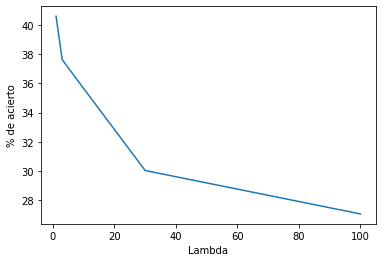

[40.59405941 37.62376238 35.64356436 30.0330033  27.06270627]


In [74]:
Epsilon = 0.12
num_iter = 750

theta1 = np.zeros((num_ocultas, num_entradas + 1))
theta2 = np.zeros((num_etiquetas, num_ocultas + 1))

lambdas = np.array([1, 3, 10, 30, 100])
percentages = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    percentages[i] = neural_network_training(theta1, theta2, num_entradas, num_ocultas, num_etiquetas, X, Y, Epsilon, lambdas[i], num_iter)

plt.plot(lambdas, percentages)
plt.xlabel("Lambda")
plt.ylabel("% de acierto")
plt.show()

print(percentages)

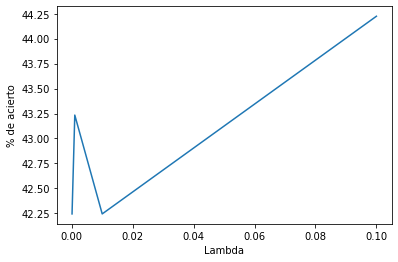

[42.24422442 43.23432343 42.24422442 44.22442244]


In [83]:
Epsilon = 0.12
num_iter = 750

theta1 = np.zeros((num_ocultas, num_entradas + 1))
theta2 = np.zeros((num_etiquetas, num_ocultas + 1))

lambdas = np.array([0.0001, 0.001, 0.01, 0.1])
percentages = np.zeros(len(lambdas))

for i in range(len(lambdas)):
    percentages[i] = neural_network_training(theta1, theta2, num_entradas, num_ocultas, num_etiquetas, X, Y, Epsilon, lambdas[i], num_iter)

plt.plot(lambdas, percentages)
plt.xlabel("Lambda")
plt.ylabel("% de acierto")
plt.show()

print(percentages)